### Lung Cancer - Exploratory Data Analysis (EDA)

#### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter 

# Define Column Names
# Based on lung-cancer.names: Attribute 1 is the class label, followed by 56 predictive attributes.
# So, the first column is 'label', and then 'attr_1' through 'attr_56'.
lung_cancer_column_names = ['label'] + [f'attr_{i}' for i in range(1, 57)]

#### 1. Load the Lung Cancer Dataset

In [11]:
# --- 2. Load the Dataset ---
file_path = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\lung+cancer\lung-cancer.data'

# The file is likely comma-separated (common for UCI).
# Crucially, missing values are denoted by '?', so we use na_values=['?'].
# header=None because the file does not contain a header row.
try:
    lung_cancer_df = pd.read_csv(file_path, header=None, names=lung_cancer_column_names, na_values=['?'])
    print("Lung Cancer Dataset loaded successfully!")
    print("First 5 rows of the Lung Cancer dataset:")
    print(lung_cancer_df.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure 'lung-cancer.data' (or similar) is in the specified location.")
    print("Also, confirm the file name is correct (e.g., 'lung-cancer.data', 'lung-cancer.csv', 'lung-cancer.txt').")
    # Exit or handle gracefully if file not found
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    print("Please check your file format (delimiter, missing value representation) and adjust pd.read_csv parameters accordingly.")
    exit()


Lung Cancer Dataset loaded successfully!
First 5 rows of the Lung Cancer dataset:
   label  attr_1  attr_2  attr_3  attr_4  attr_5  attr_6  attr_7  attr_8  \
0      1       0       3       0     NaN       0       2       2       2   
1      1       0       3       3     1.0       0       3       1       3   
2      1       0       3       3     2.0       0       3       3       3   
3      1       0       2       3     2.0       1       3       3       3   
4      1       0       3       2     1.0       1       3       3       3   

   attr_9  ...  attr_47  attr_48  attr_49  attr_50  attr_51  attr_52  attr_53  \
0       1  ...        2        2        2        2        2        1        1   
1       1  ...        2        2        2        2        2        2        2   
2       1  ...        2        2        2        2        2        2        2   
3       1  ...        2        2        2        2        2        2        2   
4       2  ...        2        2        2        2      

#### 2. Initial Inspection

In [12]:
# --- 2. Initial Inspection
print("\nDataFrame Info:")
lung_cancer_df.info()

print("\nDescriptive Statistics (for numerical-like attributes):")
# Note: describe() will show stats for columns that look numerical.
# Since nominal features are 0-3, it will still provide min, max, mean etc.
print(lung_cancer_df.describe())

print("\nMissing values per column:")
# This will explicitly show counts for '?' which were converted to NaN
print(lung_cancer_df.isnull().sum())

# For any duplicated rows
print(f"\nNumber of duplicate rows: {lung_cancer_df.duplicated().sum()}")



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 57 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    32 non-null     int64  
 1   attr_1   32 non-null     int64  
 2   attr_2   32 non-null     int64  
 3   attr_3   32 non-null     int64  
 4   attr_4   28 non-null     float64
 5   attr_5   32 non-null     int64  
 6   attr_6   32 non-null     int64  
 7   attr_7   32 non-null     int64  
 8   attr_8   32 non-null     int64  
 9   attr_9   32 non-null     int64  
 10  attr_10  32 non-null     int64  
 11  attr_11  32 non-null     int64  
 12  attr_12  32 non-null     int64  
 13  attr_13  32 non-null     int64  
 14  attr_14  32 non-null     int64  
 15  attr_15  32 non-null     int64  
 16  attr_16  32 non-null     int64  
 17  attr_17  32 non-null     int64  
 18  attr_18  32 non-null     int64  
 19  attr_19  32 non-null     int64  
 20  attr_20  32 non-null     int64  
 21  a

#### 3. Handling Missing Values

In [13]:
# --- 3. Handle Missing Values (Example Strategy for Nominal Data) ---
# Let's see the percentage of missing values:
missing_percentage = lung_cancer_df.isnull().sum() / len(lung_cancer_df) * 100
print("\nPercentage of Missing Values per Column: ")
print(missing_percentage[missing_percentage > 0])

# For nominal features with few missing values, mode imputation is common.
# For attributes 5 and 39 (which are 'attr_4' and 'attr_38' in 0-indexed DataFrame):
for col in ['attr_4', 'attr_38']: # These correspond to original attributes 5 and 39
    if lung_cancer_df[col].isnull().any():
        mode_val = lung_cancer_df[col].mode()[0] # Calculate mode - good untuk cari average 
        lung_cancer_df[col].fillna(mode_val, inplace=True)
        print(f"Missing values in '{col}' imputed with mode: {mode_val}")

print("\nMissing values after imputation:")
print(lung_cancer_df.isnull().sum().sum()) # Total missing values should now be 0



Percentage of Missing Values per Column: 
attr_4     12.500
attr_38     3.125
dtype: float64
Missing values in 'attr_4' imputed with mode: 1.0
Missing values in 'attr_38' imputed with mode: 2.0

Missing values after imputation:
0


C:\Users\User\AppData\Local\Temp\ipykernel_22152\1793952503.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lung_cancer_df[col].fillna(mode_val, inplace=True)


#### 4. Seperate Features (X) and Target (y)

In [14]:
# --- 4. Separate Features (X) and Target (y) ---
# 'label' is the first column.
X_lung = lung_cancer_df.drop('label', axis=1) # drop column but if axis = 0 drop ny row
y_lung = lung_cancer_df['label']

print(f"\nShape of features (X_lung): {X_lung.shape}")
print(f"Shape of target (y_lung): {y_lung.shape}")


Shape of features (X_lung): (32, 56)
Shape of target (y_lung): (32,)


#### 5. Explore Target Variable Distribution (Original 3 Classes)


Distribution of 'label' (original 3 classes):
label
2    13
3    10
1     9
Name: count, dtype: int64

Percentage distribution of 'label':
label
2    40.625
3    31.250
1    28.125
Name: proportion, dtype: float64


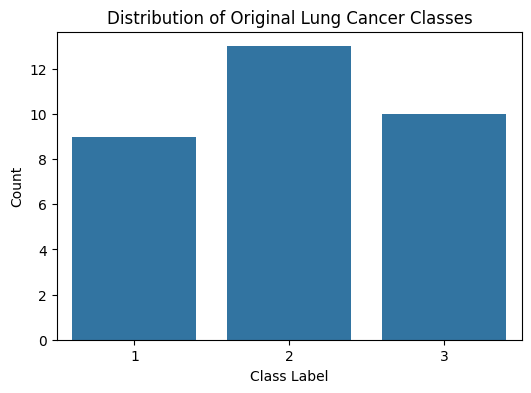

In [15]:
print("\nDistribution of 'label' (original 3 classes):")
print(y_lung.value_counts())
print("\nPercentage distribution of 'label':")
print(y_lung.value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_lung)
plt.title('Distribution of Original Lung Cancer Classes')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

#### 6. Restructure to Binary Classification 


Distribution of 'label' (after binary restructuring):
label
1    23
0     9
Name: count, dtype: int64

Percentage distribution of 'label' (after binary restructuring):
label
1    71.875
0    28.125
Name: proportion, dtype: float64


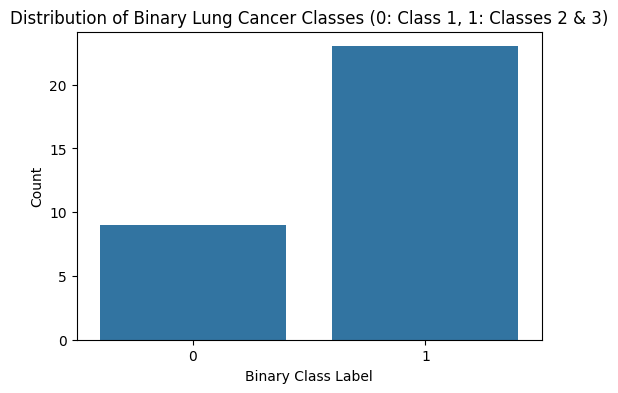

In [16]:
# This is a crucial step for the Lung Cancer dataset.
# Example: Map class 1 to 0 (negative), and classes 2 & 3 to 1 (positive).
# You will need to decide on the exact mapping based on domain knowledge or project needs.
# For this example, let's assume we want to classify 'class 1' vs 'other classes'.

# 1 → 0 (treated as the “negative class” — maybe normal/healthy or baseline)
# 2 or 3 → 1 (treated as the “positive class” — maybe different disease stages)
y_lung_binary = y_lung.apply(lambda x: 0 if x == 1 else 1)

print("\nDistribution of 'label' (after binary restructuring):")
print(y_lung_binary.value_counts())
print("\nPercentage distribution of 'label' (after binary restructuring):")
print(y_lung_binary.value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_lung_binary)
plt.title('Distribution of Binary Lung Cancer Classes (0: Class 1, 1: Classes 2 & 3)')
plt.xlabel('Binary Class Label')
plt.ylabel('Count')
plt.show()

#### 7. Feature Distributions (Countplots for Nominal Features)

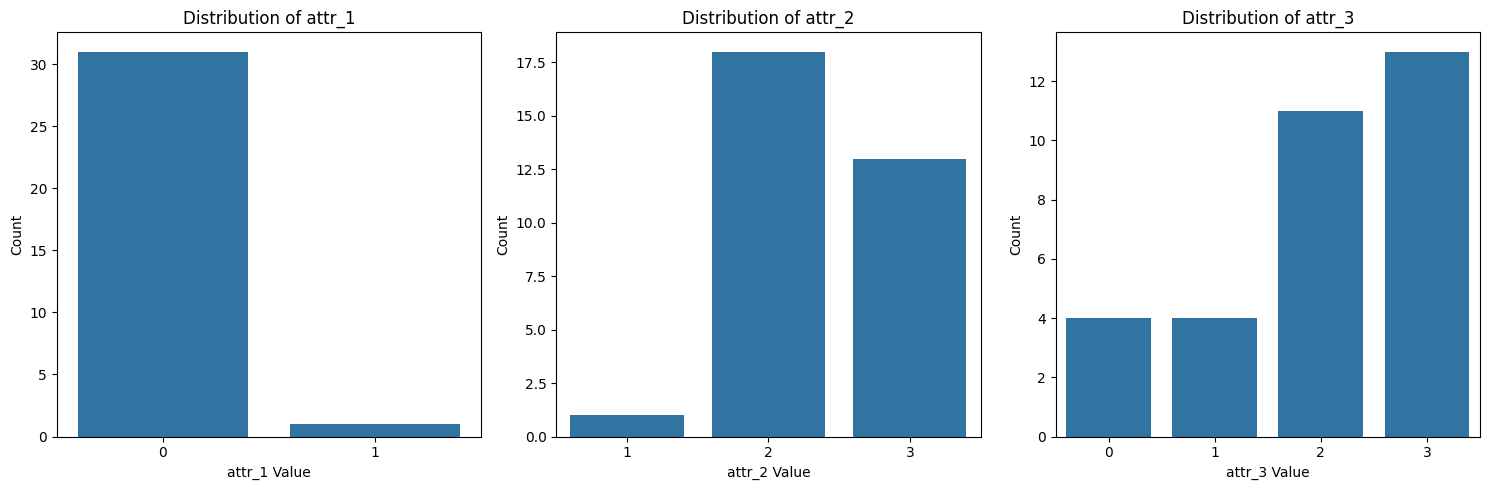


Unique values and counts for selected nominal features:
'attr_1': {0: 31, 1: 1}
'attr_2': {2: 18, 3: 13, 1: 1}
'attr_3': {3: 13, 2: 11, 0: 4, 1: 4}


In [17]:
# Since all predictive attributes are nominal (0-3), countplots are more appropriate than histograms.
# Plotting the first 3 features as an example.
features_to_plot_lung = lung_cancer_column_names[1:4] # Get attr_1, attr_2, attr_3

plt.figure(figsize=(15, 5))
for i, col_name in enumerate(features_to_plot_lung):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=X_lung[col_name])
    plt.title(f'Distribution of {col_name}')
    plt.xlabel(f'{col_name} Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nUnique values and counts for selected nominal features:")
for col in features_to_plot_lung:
    print(f"'{col}': {X_lung[col].value_counts().to_dict()}")

#### 8. Considerations for Correlation Heatmap

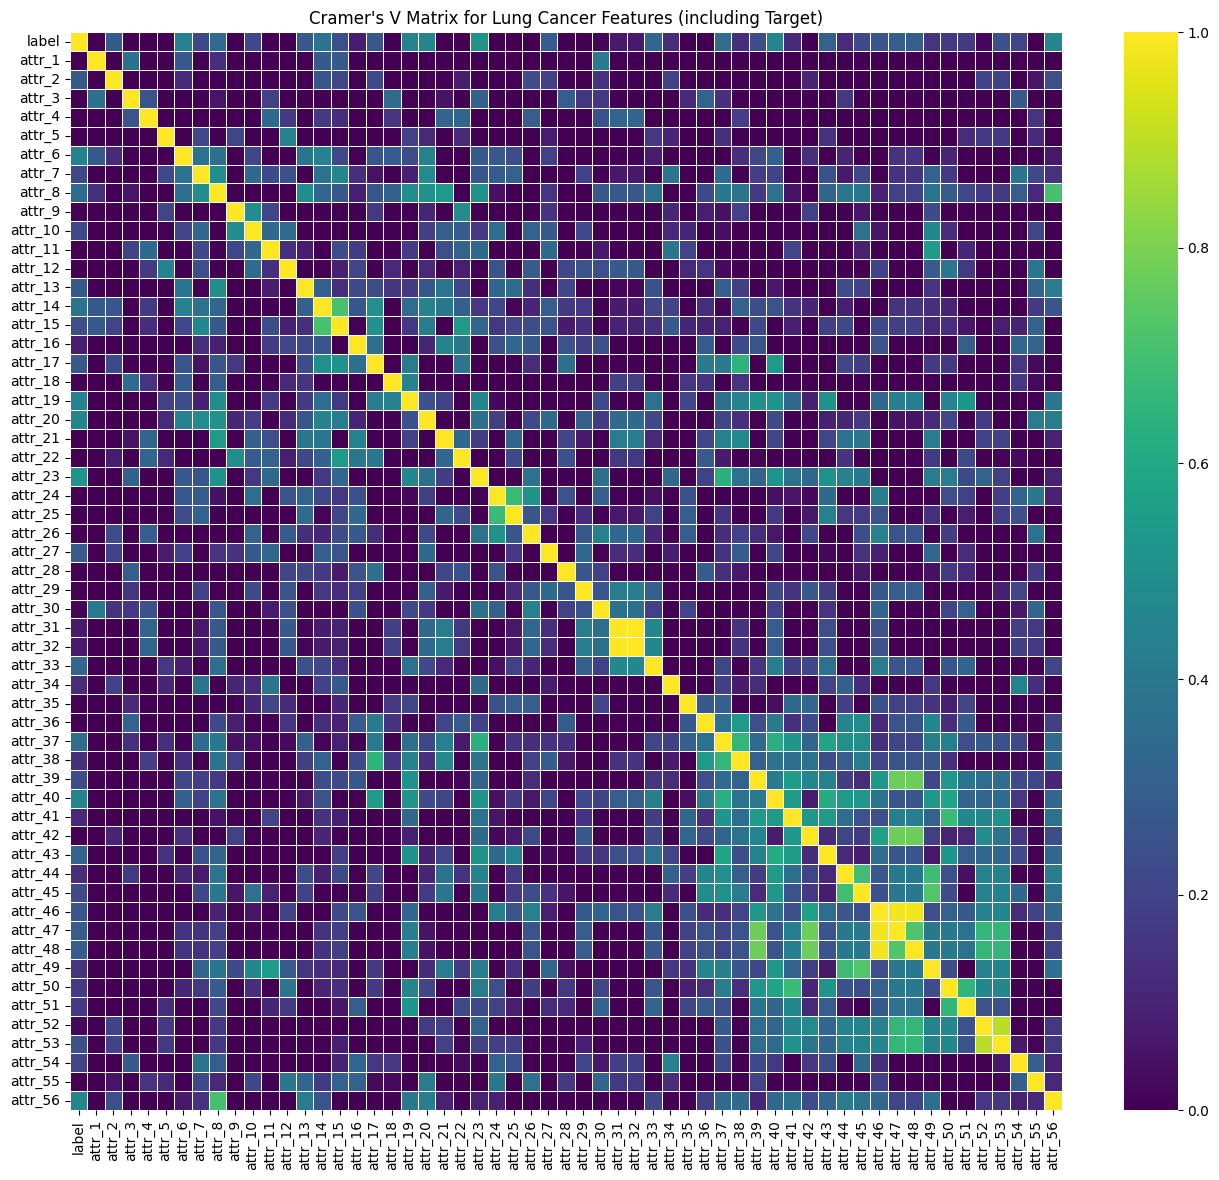

' \nAdditional Notes :\n0 -> No association\n1 -> Perfect association\nWith small N (have 32 for this case), the bias corrected version is much safer\n\n'

In [ ]:
# --- 8. No direct correlation heatmap for purely nominal features without encoding ---
# Standard Pearson correlation is for numerical data.
# If want to see relationships between nominal features, you'd typically use:
# - Chi-squared test for independence
# - Cramer's V (based on chi-squared) for strength of association.
# - Or, convert them to numerical (e.g., one-hot encode) first.
# For now, we'll skip a heatmap until encoding is done, as it won't be very informative with raw nominals.
# print("\nNote: Skipping direct correlation heatmap as features are nominal (0-3).")
# print("Relationships between nominal features are better explored using techniques like Chi-squared test or Cramer's V after encoding.")

# Cramers V -  a measure from statistics that calculates the strength of association between two categorical variables
# First option is using the chi square independence test.
# A p value close to zero will mean that our variable are very unlikely to be completely unassociated in some population.
from scipy.stats import chi2_contingency
from collections import Counter

# Make the Cramers V funtion
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0] # Calculates the Chi-Squared X^2 statistic for the contingency table.
    n = confusion_matrix.sum().sum() # gets the total number of observations, n, by summing all the values in the contingency table
    phi2 = chi2 / n # Calculates the phi-squared value (I guess follow the formula)
    r, k = confusion_matrix.shape # r - number of row categories, k - number of column categories - overall to get the dimensions of contingency table

    # Bias correction used for small samples.
    # To prevent overestimating the association
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 

    # Calculate the corrected number of rows (rcorr) and columns (kcorr) as part of the bias correction formula
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) if min((kcorr-1), (rcorr-1)) > 0 else 0

# Build V matrix
df_for_cramers = lung_cancer_df.copy() # Do on copy and dont bother the original - to ensure that the original data remains unchanged 
num_features = df_for_cramers.shape[1] # Gets the total number of columns(features) in dataframe
cramers_matrix = pd.DataFrame(index=df_for_cramers.columns, columns=df_for_cramers.columns) # A new empty DataFrame is created to hold the Cramer's V values. It has the same rows and columns, with the column names as labels.

# Loops over the upper triangle, set diagonal to 1.0 and mirrors each computed value to keep the matrix symmetric
for i in range(num_features):
    for j in range(i, num_features):  # upper triangle only
        col1 = df_for_cramers.columns[i]
        col2 = df_for_cramers.columns[j]
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0 # the cramers v is always 1.0, representing a perfect association
        else:
            v_val = cramers_v(df_for_cramers[col1], df_for_cramers[col2]) # to calculate the association for each pair of features
            cramers_matrix.loc[col1, col2] = v_val
            cramers_matrix.loc[col2, col1] = v_val  # mirror to lower triangle

cramers_matrix = cramers_matrix.astype(float) # Ensures that all values in matrix are in the correct data type

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(cramers_matrix, cmap='viridis', annot=False, fmt=".2f", linewidths=.5)
plt.title("Cramer's V Matrix for Lung Cancer Features (including Target)")
plt.show()


''' 
Additional Notes :
0 -> No association
1 -> Perfect association
With small N (have 32 for this case), the bias corrected version is much safer

'''

In [ ]:
# Example of summarized computed cramers v

label_assoc = {col: cramers_v(df_for_cramers[col], df_for_cramers['label'])
               for col in df_for_cramers.columns if col != 'label'}
pd.Series(label_assoc).sort_values(ascending=False).head(10)


attr_23    0.511742
attr_56    0.463302
attr_20    0.455433
attr_40    0.449875
attr_19    0.444869
attr_6     0.436892
attr_14    0.379475
attr_37    0.349266
attr_8     0.346024
attr_33    0.325546
dtype: float64

#### 9. Outlier detection (Boxplots for Nominal Features)


Countplots for selected attributes (nominal features):


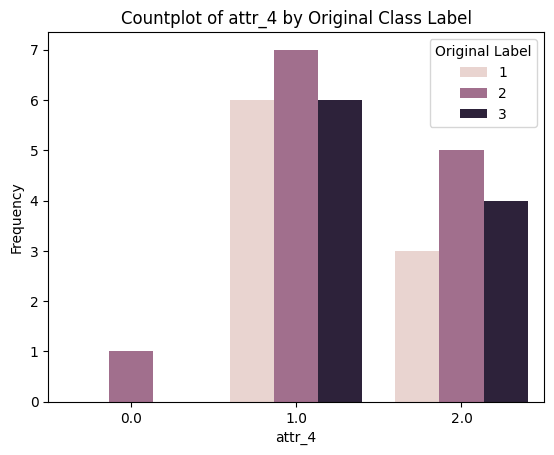

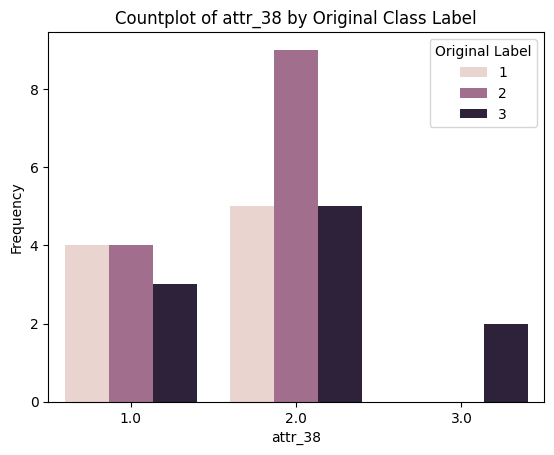

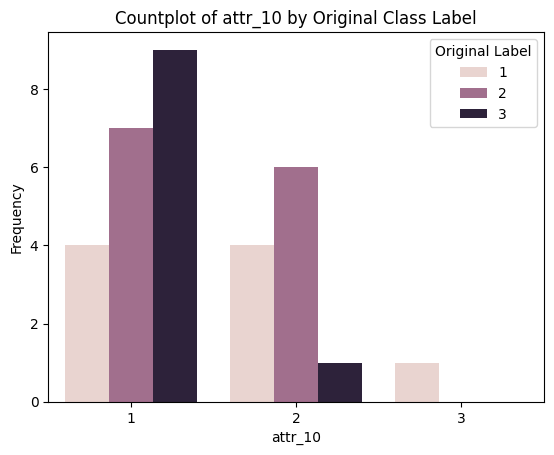

' \nattr_4, attr_38 - chosen because they are the ones having missing values\nattr_10 - just random extra sample to illustrate process.\n\nWhy using Countplots ?\n\n- Simply put, Boxplots good for ordinal data and countplots good for nominal data\n- Therefore, the boxplots dint show what range of numbers that are misrecorded \nbut if countplots the specific numbers of number as well as its frequency are shown \n\n'

In [22]:
# --- 10. Distribution Check for Nominal Features (CountPlots) ---
# Since the Lung Cancer dataset attributes are nominal (categorical),
# countplots are more suitable than boxplots. They clearly show:
#   - Each distinct category value
#   - How often each category appears (frequency)
# This makes it easier to spot suspicious or mis-recorded values
# In simple, outliers are important to detect because it could be a typo or mis-recorded value

print("\nCountplots for selected attributes (nominal features):")
for feat in ['attr_4', 'attr_38', 'attr_10']:  # attr_4 & attr_38 had missing values, attr_10 is extra sample
    plt.figure()
    sns.countplot(x=feat, hue='label', data=lung_cancer_df)
    plt.title(f"Countplot of {feat} by Original Class Label")
    plt.xlabel(feat)
    plt.ylabel("Frequency")
    plt.legend(title="Original Label")
    plt.show()

''' 
attr_4, attr_38 - chosen because they are the ones having missing values
attr_10 - just random extra sample to illustrate process.

Why using Countplots ?

- Simply put, Boxplots good for ordinal data and countplots good for nominal data
- Therefore, the boxplots dint show what range of numbers that are misrecorded 
but if countplots the specific numbers of number as well as its frequency are shown 

'''

#### 10. Scaling and PCA (Applied after implicit numerical treatment for nominals)


Applying StandardScaler to features:
Shape of scaled features (X_lung_scaled): (32, 56)
First 5 rows of scaled features (showing a snippet):
[[-0.1796053   1.14707867 -2.00118448 -0.64044476 -0.62554324]
 [-0.1796053   1.14707867  0.95441106 -0.64044476 -0.62554324]
 [-0.1796053   1.14707867  0.95441106  1.22266727 -0.62554324]
 [-0.1796053  -0.6882472   0.95441106  1.22266727  1.59861051]
 [-0.1796053   1.14707867 -0.03078745 -0.64044476  1.59861051]]

Applying PCA for dimensionality reduction:


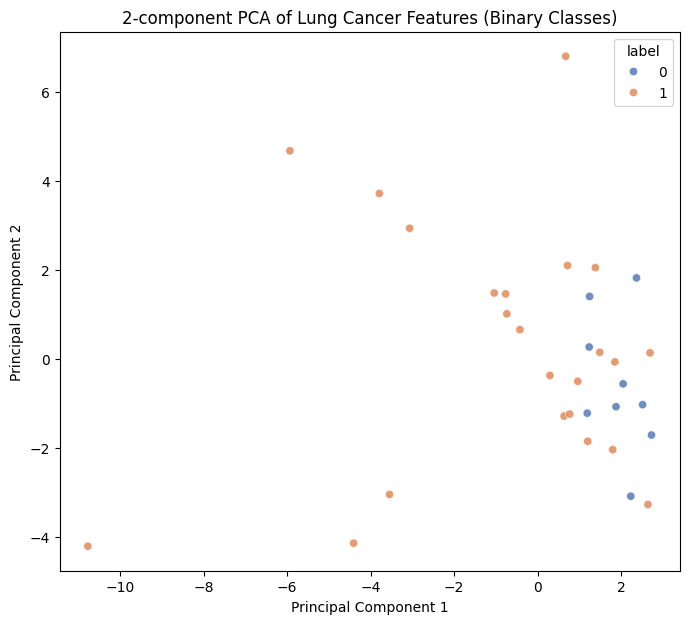


Variance explained by 2 principal components:
[0.1535552  0.10766808]
Total variance explained: 26.12%


In [23]:
# Proposal mentions PCA for dimensionality reduction and StandardScaler for preprocessing.
# For nominal features like 0-3, these operations treat them as ordinal numbers.
# If these were truly unordered categories, one-hot encoding before scaling/PCA would be more appropriate.
# However, given your proposal's mention, we'll proceed assuming they are treated numerically/ordinally.

# Ensure X_lung is of a numeric type for scaling and PCA
X_lung = X_lung.astype(float) # Convert to float if not already to handle NaN during scaling if not imputed

print("\nApplying StandardScaler to features:")
scaler = StandardScaler()
X_lung_scaled = scaler.fit_transform(X_lung)
print(f"Shape of scaled features (X_lung_scaled): {X_lung_scaled.shape}")
print("First 5 rows of scaled features (showing a snippet):")
print(X_lung_scaled[:5, :5]) # Print first 5 rows and 5 columns of the scaled array


print("\nApplying PCA for dimensionality reduction:")
# Given the small dataset size (32 instances) and 56 features,
# PCA might not provide clear separation, or could overfit to the small sample.
# Number of components can be at most min(n_samples, n_features) - 1 if features are perfect linear combinations
# Here, it's min(32, 56) = 32.
# Try 2 components as specified in the proposal (general approach).
pca_lung = PCA(n_components=2)
pca_components_lung = pca_lung.fit_transform(X_lung_scaled)

plt.figure(figsize=(8,7))
# Use the binary target for the PCA plot as per your project's objective for classification
sns.scatterplot(x=pca_components_lung[:,0], y=pca_components_lung[:,1], hue=y_lung_binary, palette='deep', alpha=0.8)
plt.title("2-component PCA of Lung Cancer Features (Binary Classes)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print("\nVariance explained by 2 principal components:")
print(pca_lung.explained_variance_ratio_)
print(f"Total variance explained: {np.sum(pca_lung.explained_variance_ratio_)*100:.2f}%")

# Ordinal data - data that can be categorized and ranked - Eg : Ranks of olympic medalist gitu (warrior, legend, mythic)
# Nominal data can only be categorized - Eg : City of birth, pencil, gender